##  $$\color{blue}{\text{Gaussian Non-White Noise Input: System Analysis}} $$

#### <center> Haley Higginbotham, 14 May 2023

Version Notes:  
-  14 May 2023 based on Sallen-Key Filter Stochastic Input System code by Ian Hunter

#### Objectives

In the following we use stochastic system identification techniques to determine a nonparametric model of a second-order band-pass analog filter

A second-order parametric transfer function model is fitted to the data using a nonlinear minimization technique

#### Import libraries

In [3]:
import numpy as np # works with complex but one of the arguments must be complex
import matplotlib.pyplot as plt
from scipy import signal
from digilent import discovery
import time
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets
import csv
from numpy import loadtxt
import datetime
%matplotlib inline
#%matplotlib widget 
%config InlineBackend.figure_format = 'svg' # this is key to improving plot resolution

#### Load Data

In [4]:
# gaussian non-white signal generated, u
# signal sent through W1 (should be same as u), x
# output signal, y

# load numpy array from csv file

# action required: imput filenames!
utemp = loadtxt('2.131 DMA Data/Gaussian/Dgauss_file.csv', delimiter=',',usecols = (1))
xtemp = loadtxt('2.131 DMA Data/Gaussian/Dgauss_file.csv', delimiter=',',usecols = (1))
ytemp = loadtxt('2.131 DMA Data/Gaussian/Fgauss_file.csv', delimiter=',',usecols = (1))


#if ytemp.size > xtemp.size:
#    y = ytemp[:(xtemp.size)]
#    x = xtemp
#else:
#    x = xtemp[:(ytemp.size)]
#    u = utemp[:(ytemp.size)]
#    y = ytemp
u = utemp[216:8700]
x = xtemp[216:8700]
y = ytemp[216:8700]
    
t = np.linspace(0,round(y.size*0.012),y.size)


#### Set x and y mean to zero

The Op Amp used in the Sallen-Key filter is high quality and should produce a zero voltage output when the input is zero. However just in case we have a slight offset voltage we will set the signal means to zero. 

In [5]:
xmean=np.mean(x)
ymean=np.mean(y)
#x=x-xmean
#y=y-ymean

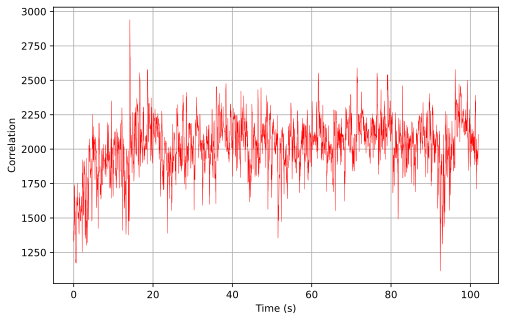

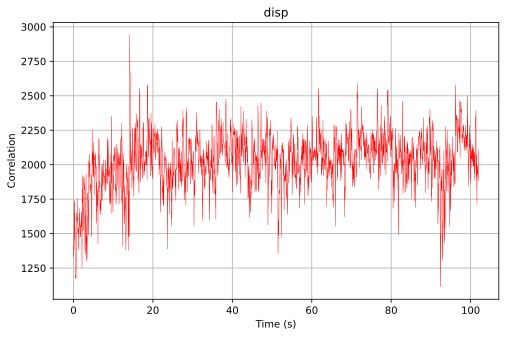

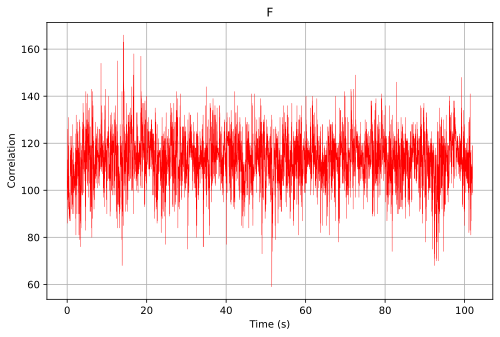

In [6]:
plt.rcParams['figure.figsize'] = [8, 5]
fig, ax = plt.subplots()
ax.plot(t, x, 'r',linewidth=0.4)
ax.set(xlabel='Time (s)', ylabel='Correlation', title='')
ax.grid()
plt.show()

plt.rcParams['figure.figsize'] = [8, 5]
fig, ax = plt.subplots()
ax.plot(t, u, 'r',linewidth=0.4)
ax.set(xlabel='Time (s)', ylabel='Correlation', title='disp')
ax.grid()
plt.show()

plt.rcParams['figure.figsize'] = [8, 5]
fig, ax = plt.subplots()
ax.plot(t, y, 'r',linewidth=0.4)
ax.set(xlabel='Time (s)', ylabel='Correlation', title='F')
ax.grid()
plt.show()

#### Plot u, x and y signals

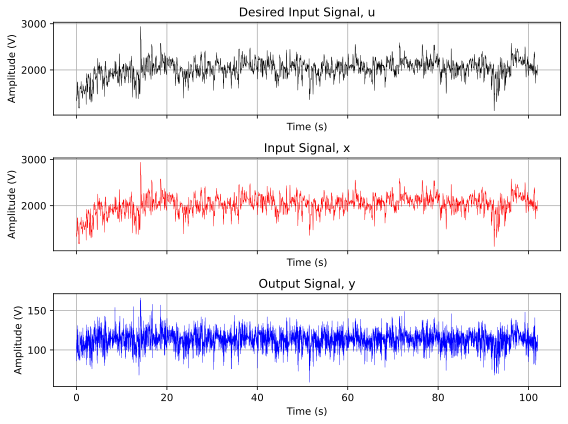

In [7]:
fig,(ax1,ax2,ax3) = plt.subplots(figsize=(8,6),nrows=3, ncols=1, sharex=True)
ax1.plot(t, u, 'k',linewidth=0.4) 
ax1.set(xlabel='Time (s)', ylabel='Amplitude (V)', title='Desired Input Signal, u')
ax1.grid()
ax2.plot(t, x, 'r',linewidth=0.4)
ax2.set(xlabel='Time (s)', ylabel='Amplitude (V)', title='Input Signal, x')
ax2.grid()
ax3.plot(t, y, 'b',linewidth=0.4)
ax3.set(xlabel='Time (s)', ylabel='Amplitude (V)', title='Output Signal, y')
ax3.grid()
plt.tight_layout()
plt.show()

Lets zoom in:

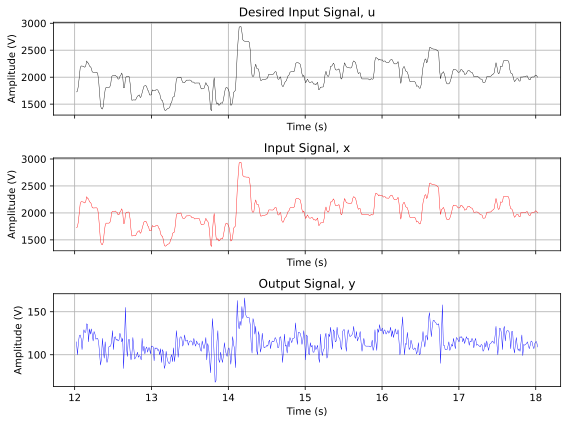

In [8]:
fig,(ax1,ax2,ax3) = plt.subplots(figsize=(8,6),nrows=3, ncols=1, sharex=True)
i1=1000
i2=i1+500
ax1.plot(t[i1:i2], u[i1:i2], 'k',linewidth=0.4) 
ax1.set(xlabel='Time (s)', ylabel='Amplitude (V)', title='Desired Input Signal, u')
ax1.grid()
ax2.plot(t[i1:i2], x[i1:i2], 'r',linewidth=0.4)
ax2.set(xlabel='Time (s)', ylabel='Amplitude (V)', title='Input Signal, x')
ax2.grid()
ax3.plot(t[i1:i2], y[i1:i2], 'b',linewidth=0.4)
ax3.set(xlabel='Time (s)', ylabel='Amplitude (V)', title='Output Signal, y')
ax3.grid()
plt.tight_layout()
plt.show()

We can see that the desired, u, and actutal, x, input signals are similar. The output signal y, has clearly been lowpass filtered.

#### Determine probability density of each signal

The standard deviation (or its square the variance) does not give us sufficient insight into the amplitude content (or structure) of a signal. A common way to quantify this is the signal probability density function (sometimes called the histogram). Note that the probability density function is normalized with respect to both the total number of samples in the signal as well as the bin widths used to estimate it. As a result the area under the probability density function = 1.

c:\Users\hhigginb\anaconda3\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


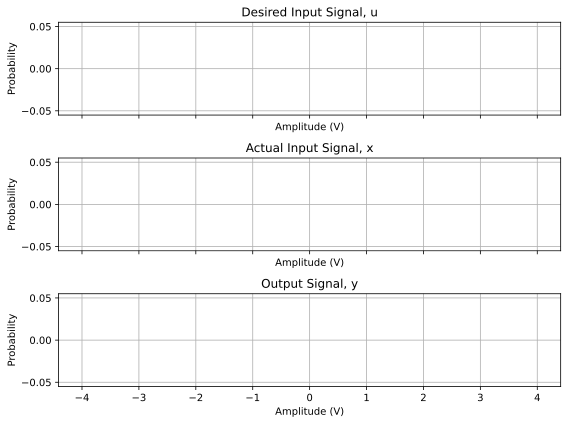

In [9]:
fig,(ax1,ax2,ax3) = plt.subplots(figsize=(8,6),nrows=3, ncols=1, sharex=True)
ax1.hist(u, density=True,range=[-4.01,4.01], bins=100,histtype='step',color='k')
ax1.set(xlabel='Amplitude (V)', ylabel='Probability', title='Desired Input Signal, u')
ax1.grid()
ax2.hist(x, density=True,range=[-4.01,4.01], bins=100,histtype='step',color='r')
ax2.set(xlabel='Amplitude (V)', ylabel='Probability', title='Actual Input Signal, x')
ax2.grid()
ax3.hist(y, density=True,range=[-4.01,4.01], bins=5000,histtype='step',color='b')
ax3.set(xlabel='Amplitude (V)', ylabel='Probability', title='Output Signal, y')
ax3.grid()
plt.tight_layout()
plt.show()

We can see that the output from the Sallen-Key filter has become more Gaussian like (for the binary input condition).
Note that the probability density function contains no information about the sequential characteristics (e.g., auto-correlation function, power spectrum) of a signal. Imagine if you scrambled the order of the samples in a signal. The probability density would remain unchanged but the power spectrum would usually change (unless the signals power spectrum was already flat (i.e., white)).
Note that there are alternative (and sometimes better) ways to compute probability density functions. These alternative methods will be covered in subsequent notes.

#### Determine x auto-correlation function 

We need a way to represent the sequential characteristics (structure) of a signal. The two main ways are to compute:
1. the auto-correlation function, which shows the memory that a signal has for itself, and
2. the power spectrum, which shows the frequency content of the signal.

The auto-correlation function and the power spectrum of a signal are a Fourier transform pair. That is: the Fourier transform of the auto-correlation function is the power spectrum and the inverse Fourier transform of the power spectrum is the auto-correlation function. For this reason the auto-correlation function may be computed directly ("direct" or "brute force method") or indirectly via the powerful fast Fourier transform (FFT) algorithm. In previous notes we used the direct method as implemented in numpy. Here we use scipy which provides both the 'direct' and 'fft' methods. We will use the method='fft'.

In [10]:
n = y.size
dt = 0.012
cxx2=signal.correlate(x,x,mode='same',method='fft')
tau=np.arange(-0.5*n*dt, 0.5*n*dt, dt) # auto-correlation function lags

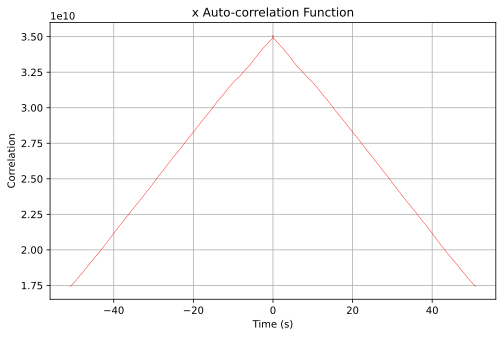

In [11]:
plt.rcParams['figure.figsize'] = [8, 5]
fig, ax = plt.subplots()
ax.plot(tau, cxx2, 'r',linewidth=0.4)
ax.set(xlabel='Time (s)', ylabel='Correlation', title='x Auto-correlation Function')
ax.grid()
plt.show()

Note that auto-correlation functions are symetric about a lag of 0. Note also that we have a spike at lag zero and the
correlation values are near zero for non-zero lags. This is expected when the signal is white (i.e., has a flat power spectrum).

Because of its symmetry, just the positive lag side of the auto-correlation function is usually plotted:

#### Show one-sided x auto-correlation function

In [12]:
cxx2=signal.correlate(x,x,mode='same',method='fft')
cxx=cxx2[round(n/2):n] # extract the last n/2 values 
tau=np.arange(0, 0.5*n*dt, dt) # auto-correlation function lags

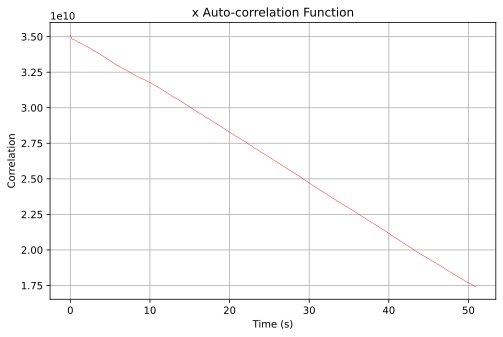

In [13]:
plt.rcParams['figure.figsize'] = [8, 5]
fig, ax = plt.subplots()
ax.plot(tau,cxx, 'r',linewidth=0.4)
ax.set(xlabel='Time (s)', ylabel='Correlation', title='x Auto-correlation Function')
ax.grid()
plt.show()

Note that we have calculated the auto-correlation functions out to a lag of over 2.5 s. This is half the duration of the signals. It is a rough rule of thumb that the maximum lag of auto-correlation functions should be considerably smaller (e.g., 10 x) than the signal duration. The reason for this is that fewer samples are involved in computing the correlation function values at longer lags. This results in estimates having larger error. It will not have much effect here but when we come (see below) to deconvolve the auto-correlation function of x from the cross-correlation function between x and y then it becomes important to keep the maximum lag considerably smaller than the signal duration.

Lets zoom in on the initial region:

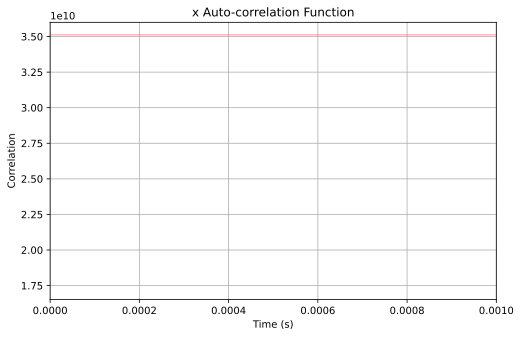

In [14]:
plt.rcParams['figure.figsize'] = [8, 5]
fig, ax = plt.subplots()
ax.plot(tau,cxx, 'r',linewidth=0.4)
ax.set(xlabel='Time (s)', ylabel='Correlation', title='x Auto-correlation Function')
ax.grid()
plt.xlim([0,0.001])
plt.show()

We can see that the auto-correlation function has some non-zero values initially. If the signal was white then the auto-correlation function would have spike at zero and would be essentially zero for non zero lags. As the power spectrum is the Fourier transform of the auto-correlation function then an auto-correlation function having a shape like that of a Dirac delta function will have a flat power spectrum (i.e., a white noise signal).
The filter has smoothed out the signal by a small amount and so we see these non-zero values at lags greater than 0. 

#### Determine y auto-correlation function 

In [15]:
cyy2=signal.correlate(y,y,mode='same',method='fft')
tau=np.arange(-0.5*n*dt, 0.5*n*dt, dt) # auto-correlation function lags

In [16]:
print(tau.size)

8484


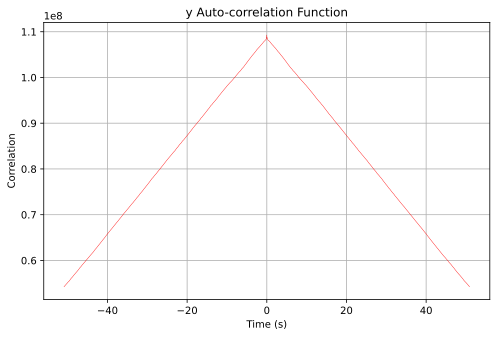

In [17]:
plt.rcParams['figure.figsize'] = [8, 5]
fig, ax = plt.subplots()
ax.plot(tau, cyy2, 'r',linewidth=0.4)
ax.set(xlabel='Time (s)', ylabel='Correlation', title='y Auto-correlation Function')
ax.grid()
plt.show()

#### Show one-sided y auto-correlation function

In [18]:
cyy=cyy2[round(n/2):n] # extract the last n/2 values 
tau=np.arange(0, 0.5*n*dt, dt) # auto-correlation function lags

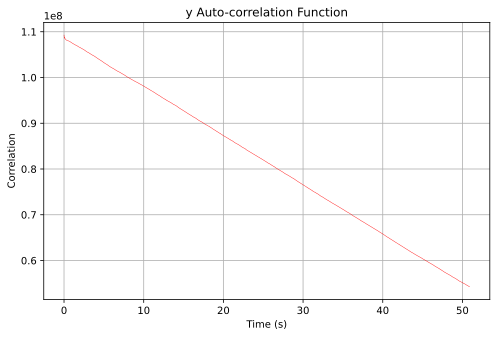

In [19]:
plt.rcParams['figure.figsize'] = [8, 5]
fig, ax = plt.subplots()
ax.plot(tau,cyy, 'r',linewidth=0.4)
ax.set(xlabel='Time (s)', ylabel='Correlation', title='y Auto-correlation Function')
ax.grid()
plt.show()

Lets zoom in on the initial region:

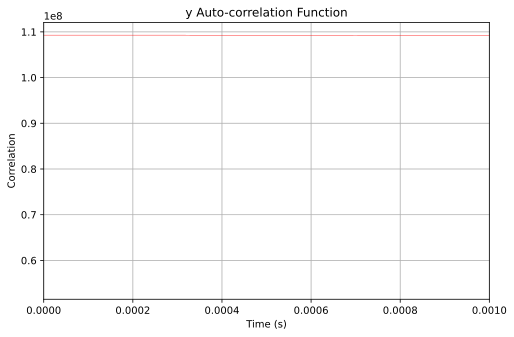

In [20]:
plt.rcParams['figure.figsize'] = [8, 5]
fig, ax = plt.subplots()
ax.plot(tau,cyy, 'r',linewidth=0.4)
ax.set(xlabel='Time (s)', ylabel='Correlation', title='y Auto-correlation Function')
ax.grid()
plt.xlim([0,0.001])
plt.show()

Here we see the effect of the Sallen-Key filter on the output auto-correlation function.

#### Calculate u, x and y power spectra

There are a few ways to determine the power spectrum of a signal. One way (as detailed in previous notes) is to exploit the fact that the Fourier transform of the auto-correlation function of a signal is the power spectrum of that signal (conversely, the inverse Fourier transform of the power spectrum is the auto-correlation function). The auto-correlation function and the power spectrum are a Fourier transform pair.
Another more direct approach is to compute the magnitude of the square of the Fourier transform of the signal:

The sampling rate, 200 kHz, is the reciprocal of the inter-sample interval (5 us). Note that the power spectrum is defined from 0 to half the sampling rate: 200 kHz/2 = 100 kHz. 
This is called the Nyquist frequency (or sometimes the Nyquist folding frequency) and is the highest frequency in the signal that can be determined. Indeed, any frequencies higher than this in the original analog signal (before it was sampled) will get aliased down into the 0 to Nyquist frequency range (see separate notes on aliasing).

In previous notes we determined the power spectrum using the periodogram function in the signal package. This time we will use a more sophisticated algorithm called Welch's method where we can specify a number of algorithmic options (see https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html#scipy.signal.welch).

Welch’s method involves determining an estimate of the power spectral density by dividing the data into overlapping segments, computing a modified periodogram for each segment and then averaging the periodograms. It also allows for selection of a variety of window functions which are applied to each segment (these are used to reduce leakage from one frequency to adjacent frequencies). The Hanning ('Hann') window function is used here (by default). The degree of overlap is another parameter which can be set.

Here we will use the defaults for all parameters except the segment length (nperseg) which we will usually set to a power of 2 (e.g., 512). Try changing this parameter and you will see that it affects the amount of spectral smoothing:

In [21]:
nseg=2**9
f, Puu = signal.welch(u, 1/dt, nperseg=nseg)
f, Pxx = signal.welch(x, 1/dt, nperseg=nseg)
f, Pyy = signal.welch(y, 1/dt, nperseg=nseg)

and plot the power spectra on a log-log plot:

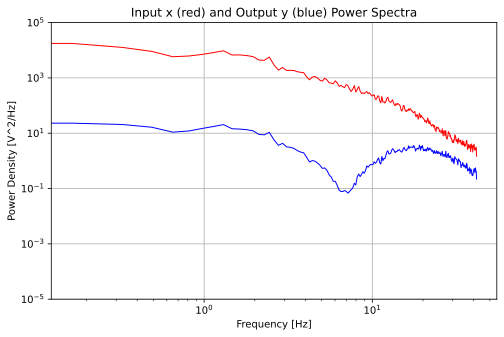

In [22]:
plt.rcParams['figure.figsize'] = [8, 5]
fig, ax = plt.subplots()
plt.loglog(f, Pxx,'r',linewidth=1)
plt.loglog(f, Pyy,'b',linewidth=1)
plt.ylim([1e-5, 1e5])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Density [V^2/Hz]')
plt.title('Input x (red) and Output y (blue) Power Spectra')
ax.grid()
plt.show()

We can see that the signal, u, sent to the Sallen-Key filter and the measured signal delivered, x, have similar flat power spectra up to 20 kHz and then they rool off qucikly (remember that the filter used to design the input is a 6th-order filter so the roll off will be somewhat abrupt (its slope should be -6 on a log log plot) (u is hidden under x).

The output of the filter, y, is flat at low frequencies but then rolls off at around 1.5 kHz.

The sampling rate, 200 kHz, is the reciprocal of the inter-sample interval (5 us). Note that the power spectrum is defined from 0 to half the sampling rate: 200 kHz/2 = 100 kHz. 
As mentioned in previous notes this is called the Nyquist frequency (or sometimes the Nyquist folding frequency) and is the highest frequency in the signal that can be determined. Indeed any frequencies higher than this in the orignal analog signal (before it was sampled) will get aliased down into the 0 to Nyquist frequency range (see separate notes on aliasing).

#### Compute x to y cross-correlation function

We now compute the cross-correlation function between the two signals, x and y. Here we use the FFT based method available in scipy which is much faster than the direct approach as implemented in numpy.

In [23]:
cxy2=signal.correlate(y,x,mode='same',method='fft')
tau=np.arange(-0.5*n*dt, 0.5*n*dt, dt) # cross-correlation function lags

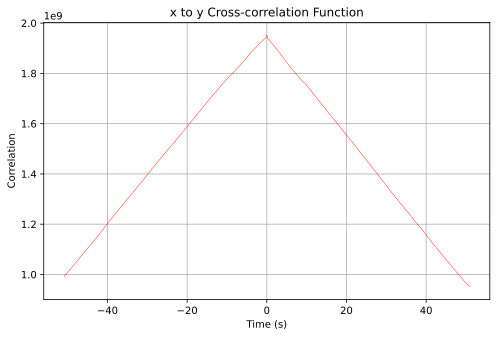

In [24]:
plt.rcParams['figure.figsize'] = [8, 5]
fig, ax = plt.subplots()
ax.plot(tau, cxy2, 'r',linewidth=0.4)
ax.set(xlabel='Time (s)', ylabel='Correlation', title='x to y Cross-correlation Function')
ax.grid()
plt.show()

Lets zoom in:

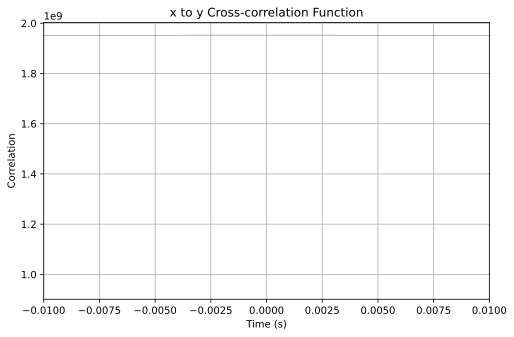

In [25]:
plt.rcParams['figure.figsize'] = [8, 5]
fig, ax = plt.subplots()
ax.plot(tau, cxy2, 'r',linewidth=0.4)
ax.set(xlabel='Time (s)', ylabel='Correlation', title='x to y Cross-correlation Function')
ax.grid()
plt.xlim([-0.01,0.01])
plt.show()

Unlike the symmetric auto-correlation functions, cross-correlation functions are asymmetric.
Let's look at the positive lag values:

#### Show one-sided xy cross-correlation function

In [26]:
cxy=cxy2[round(n/2):n] # extract the last n/2 values 
tau=np.arange(0, 0.5*n*dt, dt) # cross-correlation function lags

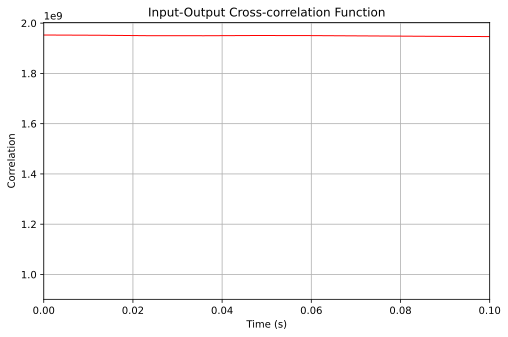

In [27]:
plt.rcParams['figure.figsize'] = [8, 5]
fig, ax = plt.subplots()
ax.plot(tau,cxy, 'r',linewidth=1)
ax.set(xlabel='Time (s)', ylabel='Correlation', title='Input-Output Cross-correlation Function')
ax.grid()
plt.xlim([0.0,0.1])
plt.show()

Let's zoom in on the cross-correlation function:

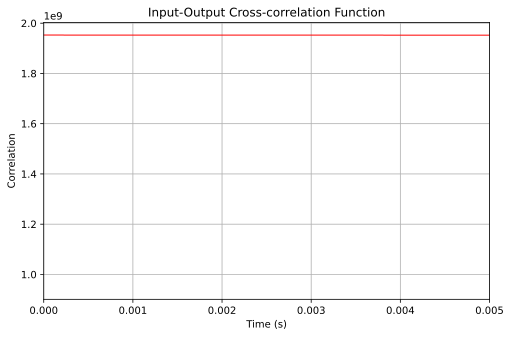

In [28]:
plt.rcParams['figure.figsize'] = [8, 5]
fig, ax = plt.subplots()
plt.xlim([0, 0.005])
ax.plot(tau,cxy, 'r',linewidth=1)
ax.set(xlabel='Time (s)', ylabel='Correlation', title='Input-Output Cross-correlation Function')
ax.grid()
plt.show()

#### Nonparametric System Impulse Response Function Estimation

An estimate of the cross-correlation function can be obtained by convolving the 
input auto-correlation function with the system impulse reponse function.
Conversely we can obtain an estimate of the system impulse response function by deconvolving the input auto-correlation function from the input-output cross-correlation function. 
This process can be implemented by solving a matrix equation involving Toeplitz matrtix inversion (see below).

In [29]:
from scipy.linalg import toeplitz, solve_toeplitz

A m x m Toeplitz matrix has a particular type of symmetry and has only m distinct values.
For example if we have a m length 1D vector called arr:

In [30]:
arr=np.arange(0,5)
arr

array([0, 1, 2, 3, 4])

Then a Toeplitz matrix formed from arr looks like:

In [31]:
toeplitz(arr)

array([[0, 1, 2, 3, 4],
       [1, 0, 1, 2, 3],
       [2, 1, 0, 1, 2],
       [3, 2, 1, 0, 1],
       [4, 3, 2, 1, 0]])

Note that the values in each top-down left-right diagonal are the same.

In the usual approach we start by forming a Toeplitz matrix from the x auto-correlation function values. We have $2^{19}=524,288$ auto-correlation values which would give a Toeplitz matrix having  $2^{19} \times 2^{19} = 274,877,906,944$ elements. This is more than most computers can store in primary memory. 

We suspect that we need to determine the impulse response function out to at least 1 ms (see plot above). So lets compute it out to 5 ms (just to be safe) which corresponds to 1000 values. So lets set the maximum lag, m, to be 1000.

In [32]:
m=1000

In [33]:
toe=toeplitz(cxx[0:m])

We now invert this Toeplitz matrix

In [34]:
toeinv=np.linalg.inv(toe)

and matrix multiply the inverse by the cross-correlation function, cxy to give estimates of the impulse response function, h.

In [35]:
h=np.dot(toeinv,cxy[0:m])

In [36]:
tau=np.arange(0.0, (len(h)-0.5)*dt, dt)

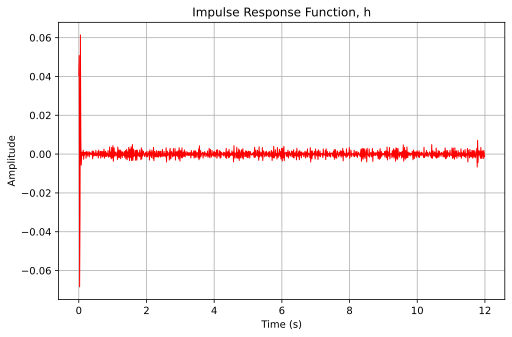

In [37]:
plt.rcParams['figure.figsize'] = [8, 5]
fig, ax = plt.subplots()
ax.plot(tau, h, 'r',linewidth=1)
ax.set(xlabel='Time (s)', ylabel='Amplitude', title='Impulse Response Function, h')
ax.grid()
plt.show()

There is a method called Levinson-Durbin recursion which avoids having to form the huge 
Toeplitz matrix explicitly. We now use this alternative algorithm which is much faster:

In [38]:
h=solve_toeplitz(cxx[0:m],cxy[0:m])/dt

As mentioned before we can think of what we have just done as deconvolving the x auto-correlation function from the xy cross-correlation function to yield the system impulse response function. 

In [39]:
tau=np.arange(0.0, (len(h)-0.5)*dt, dt)

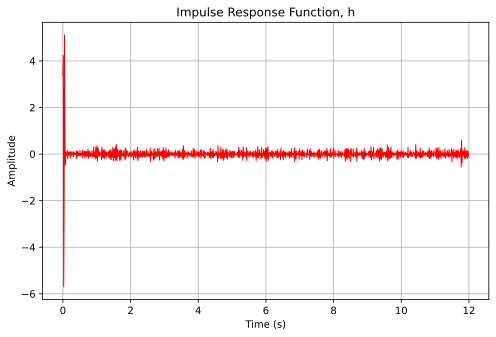

In [40]:
plt.rcParams['figure.figsize'] = [8, 5]
fig, ax = plt.subplots()
ax.plot(tau, h, 'r',linewidth=1)
ax.set(xlabel='Time (s)', ylabel='Amplitude', title='Impulse Response Function, h')
ax.grid()
plt.show()

Sometimes these approaches result in too much numerical noise. A better approach is to use singular value decomposition (SVD) which is an amazing algorithm which remains numerically stable under almost all conditions but is slower. We will consider this approach in subsequent notes.

#### Calculate Cross-Power Spectrum

We have already determined the power spectrum of the input and so now we need to compute the input to output cross-power spectrum. We can also use Welch's method for this (see https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.csd.html):

In [41]:
f, Pxy = signal.csd(x, y, 1/dt, nperseg=2**9)

The cross-power spectrum is a complex quantity so we plot the magitude:

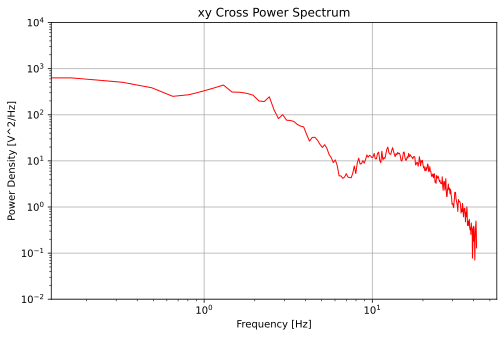

In [42]:
plt.rcParams['figure.figsize'] = [8, 5]
fig, ax = plt.subplots()
plt.loglog(f, np.abs(Pxy),'r',linewidth=1)
plt.ylim([1e-2, 1e4])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Density [V^2/Hz]')
plt.title('xy Cross Power Spectrum')
ax.grid()
plt.show()

#### Calculate Frequency Response (Bode plot)

Now that we have the input power spectrum and the input-output cross-spectrum we can determine the frequency response function, Hxy, by complex division:

$$Hxy = \frac{Pxy}{Pxx}$$

In [43]:
nseg=2**9
f, Pxx = signal.welch(x, 1/dt, nperseg=nseg)
f, Pxy = signal.csd(x, y, 1/dt, nperseg=nseg)

In [44]:
Hxy=Pxy/Pxx

#### Bode Plot Gain

We start by determining the frequency response gain (Bode plot gain).

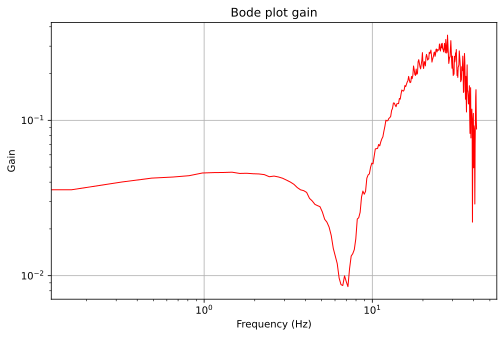

In [45]:
plt.rcParams['figure.figsize'] = [8, 5]
fig, ax = plt.subplots()
plt.loglog(f, abs(Hxy),'r',linewidth=1)
ax.set(xlabel='Frequency (Hz)', ylabel='Gain', title='Bode plot gain')
ax.grid()
plt.show()

If we had a high-pass system then we would expect the gain at low frequencies to roll off. If our system is low-pass then we would expect that at low frequencies the gain would be flat and at high frequencies the gain would roll-off. We conclude that the systemj is low-pass (at least over the frequencies measured).

We also note that the low frequency gain is 1 which indicates that we have a low-pass filter with a static gain of either +1 or -1 (see phase analysis below).

We also note that the high frequency roll-off slope on this log log plot looks as though it is equal to -2 (more about this below). If confirmed by the phase estimates (below) then it means that our system is second-order.

Note also that the system does not appear to be significantly underdamped. This suggests that the damping parameter is likely to be $\zeta>0.7$

#### Bode Plot Phase

We now determine the phase part of the frequency response function.

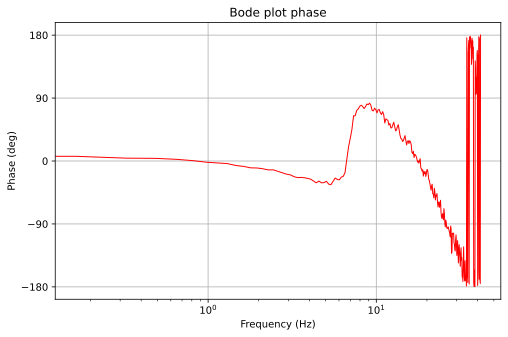

In [46]:
plt.rcParams['figure.figsize'] = [8, 5]
fig, ax = plt.subplots()
plt.semilogx(f, 360*np.angle(Hxy)/(2*np.pi),'r',linewidth=1)
ax.set(xlabel='Frequency (Hz)', ylabel='Phase (deg)', title='Bode plot phase')
ax.grid()
plt.yticks([-180,-90,0,90,180])
plt.show()

Note that phase bounces between +180 and -180 deg. As mentioned in previous notes, we need to unwrap the phase:

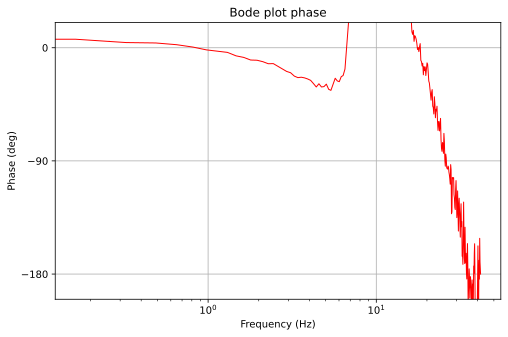

In [47]:
plt.rcParams['figure.figsize'] = [8, 5]
fig, ax = plt.subplots()
plt.semilogx(f, 360*np.unwrap(np.angle(Hxy))/(2*np.pi),'r',linewidth=1)
ax.set(xlabel='Frequency (Hz)', ylabel='Phase (deg)', title='Bode plot phase')
ax.grid()
plt.yticks([-180,-90,0])
plt.ylim([-200,20])
plt.show()

We can see that the phase starts at 0 deg. If the overall gain of the filter was negative then the low frequency phase would start at +180 deg. We therefor conclude that we have a filter with a static gain of +1. 

We also observe that the high frequency phase tends towards -180. This confirms that our system is second order (with no pure delay the high frequency phase will have an assymptote of 90 deg times the system order).

There is also no evidence of a pure delay (which would cause the phase to wander down forever).

Finally, for a second-order low-pass system with no pure delay the phase at 90 deg should occur at the natural frequency. Inspection of the plot above suggest that the natural frequency is around 1 kHz. We will get a better estimate later. 

#### Coherence Function

One of the problems in determining nonparametric frequency response functions is to figure out how much confidence should be placed in the gain and phase values at different frequencies. We would really like to know just how much of the output variance accounted for by the nonparametric model is determined at each frequency. The coherence squared function gives us exactly this. You can think of the coherence squared function as being the overall variance accounted for (VAF, covered in previous notes) split up as a function of frequency. In frequency bands where the coherence squared is high, the Bode plot gain and phase values are important. Where the coherence squared is low, we have less confidence in the values. Indeed when (or if) we subsequently fit a parametric model to the nonparametric frequency response, we can use the coherence squared values to do weighted least-squares fitting.

We can determine the coherence squared function, $C_{xy}$, using:

$$Cxy = \frac{|Pxy|^2}{Pxx.Pyy}$$

Or we use the scipy function coherence to compute the squared coherence directly from the input and output signals using Welch's algorithm (see https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.coherence.html):

In [48]:
f, Cxy = signal.coherence(x, y, 1/dt, nperseg=2**9)

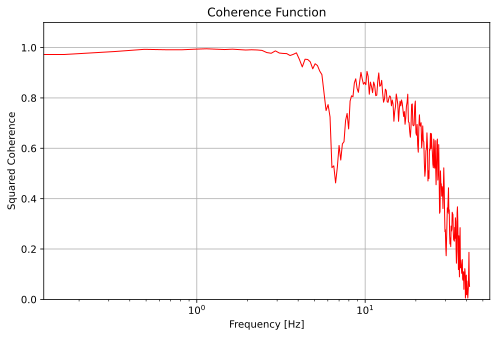

In [49]:
plt.rcParams['figure.figsize'] = [8, 5]
fig, ax = plt.subplots()
plt.semilogx(f, np.abs(Cxy),'r',linewidth=1)
plt.ylim([0, 1.1])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Squared Coherence')
plt.title('Coherence Function')
ax.grid()
plt.show()

Note that the squared coherence varies from 0 to 1. A band of frequencies where the squared coherence is near 1 indicates that the output over these frequencies is linearly dynamically dependent on the input and that the additive noise (e.g., measurement noise) at the output is small (over these frequencies). A low squared coherence indicates that either there is substantial additive noise to the output, or a linear dynamic model is inadequate (e.g., a nonlinear model may be required). It is not possible to differentiate from the squared coherence between noise and nonlinearity. 

This can be seen in the plot above the coherence squared is high until we get to around 20 kHz when it begins to decrease.

It is important to note that calculation of the squared coherence requires that the input and output spectra and the cross-spectrum are averaged or smoothed. Using Welch's method with the parameters used here ensures this. With no averaging (or smoothing) the squared coherence is exactly one and is meaningless.

#### Consideration of Model Order

The high frequency roll-off gives a clue as to model order. When plotting on Log-Log axes the Bode gain of a simple low-pass system should roll off with a slope equal to minus the system order. For example, if the order is 2 then the high frequency asymptotic roll-off slope should be -2 (i.e. the high frequency system gain becomes 100 x less as the frequency in increased 10 x). The "roll-off" evident in the gain part of the Bode plot above has an eventual slope of around -2 so we conclude that the system is second-order. This is confirmed by looking at the phase part of the Bode plot. The difference in value between the asymptotic low frequency phase value (0 deg here) and the asymptotic high frequency phase value will be -90 times the system order. In our case this phase difference is 180 deg which confirms that we have a second-order system. 

Note that the asymptotic low frequency phase value will be 180 deg rather than 0 deg if the overall static gain is negative. So in this case we can see that the overall gain of the Sallen-Key filter is positive because the low frequency phase starts at 0 and in addition it looks as though the value of the static gain, $\alpha$, (i.e. its asymptotically low frequency gain value) is 1. This can be seen in the plot below.

The cutoff frequency, $\omega_n$, will occur when the phase is half way between the low and high frequency asymptotes (-90$^o$ here). In the plot below a vertical black line has been drawn through this halfway point in the phase part of the Bode plot and extended up in to the gain part of the Bode plot. This line should intersect the black horizontal asymptotic low frequency gain line and the colored high frequency roll-off line extrapolated back to lower frequencies. See if this is indeed the case once the static gain, $\alpha$, has been adjusted:

It can be seen that the cut-off frequency (natural frequency), $\omega_n$, is around 1 kHz (or $2\pi$ 1000 rad/s).


A simple low-pass, second-order system is defined by three parameters: the static gain, $\alpha$, the natural frequency, $\omega_n$, and the damping parameter, $\zeta$. As yet we have not estimated the value of the damping parameter but from experience it looks as though it is somewhere around 1.

In the following, we allow all three parameters to be adjusted to give a feel for the effect each has on the features of the Bode plot. 

#### Fit a Parametric Second-Order Transfer Function Model by Hand

The general equation for the transfer function of a second-order low-pass filter is:

$$ H(s) = \frac{\alpha \omega _{n}^2}{s^2+2\zeta\omega_ns+\omega_n^2} $$ 

where $\alpha$ is the system static gain, $\omega_n$ is the natural frequency, and $\zeta$ is the damping parameter.

We now define a python function for H(s):

In [50]:
def tf(s,gain,damping,natfreq):
    return gain*natfreq**2/(s**2+2*damping*natfreq*s+natfreq**2)

Let's fit the transfer function by hand:

In [51]:
def plot_irf2(gain,damping,natfreq):
      
    w=np.logspace(1, 6, 80)
    tfg=np.absolute(tf(1j*w,gain,damping,2*np.pi*natfreq)) # substitute s for jw
    tfp=360*np.unwrap(np.angle(tf(1j*w,gain,damping,2*np.pi*natfreq)))/(2*np.pi) # substitute s for jw
    
    plt.rcParams['figure.figsize'] = [9, 6]
    fig, axa = plt.subplots()
    
    axb=axa.twinx()
    axb.semilogx(w/(2*np.pi), tfp,'b.',markersize=1)
    axb.semilogx(f, 360*np.unwrap(np.angle(Hxy))/(2*np.pi),'b',linewidth=1)
    axb.set(ylabel='Phase (blue)')
    axb.set_ylim([-180,45])
    axb.set_xlim([2,50])
    axb.locator_params(axis = 'y', nbins = 8)
    axb.set_yticks(np.arange(0,-182,-45))
    
    axa.loglog(w/(2*np.pi), tfg,'r.',markersize=1)
    axa.loglog(f, abs(Hxy),'r',linewidth=1)
    axa.set_ylim([0.001,10])
    axa.set_xlim([2,50])
    axa.set(xlabel='Frequency (Hz)', ylabel='Gain (red)', title='Sallen-Key Filter Measured (solid) and Estimated (dots)')
    #ax2a.set_yticks(np.arange(-4,2,1))
    #ax2a.grid()
    
    plt.tight_layout()
    
    plt.show()

Note that the natural frequency slider is in Hz

In [52]:
interact(plot_irf2, 
         gain = widgets.FloatSlider(value=0.5, min=0.1, max=5.0,step=0.01,layout=Layout(width='700px')), 
         damping = widgets.FloatSlider(value=1.5, min=0.1, max=10.0,step=0.01,layout=Layout(width='700px')),
         natfreq = widgets.FloatSlider(value=500, min=0.1, max=1000,step=1,layout=Layout(width='700px')))

interactive(children=(FloatSlider(value=0.5, description='gain', layout=Layout(width='700px'), max=5.0, min=0.…

<function __main__.plot_irf2(gain, damping, natfreq)>

Note that the natural frequency slider,  $\omega_{n}$, is in Hz (multiply by 2$\pi$ to get the natural frequency in rad/s).

Note the values of the three parameters.

#### Fit a Parametric Second-Order Transfer Function Model by Nonlinear Minimization

Let's now use a nonlinear minimization technique to fit the model to the data (actually we fit to just the gain data: it would be better to fit to both the gain and phase data simultaneously):

Note that here the natural frequency is in Hz rather than rad/s.

In [53]:
from scipy.optimize import curve_fit

In [54]:
def tfg2(f,gain, damping, natfreq):
    return np.absolute(tf(1j*2*np.pi*f,gain,damping,2*np.pi*natfreq))

In [55]:
(gainest, dampingest, natfreqest), pcov = curve_fit(tfg2,f,abs(Hxy),p0=[1,1,1000],method='lm') 

In [56]:
(gainest, dampingest, natfreqest)

(0.1555606082498892, -50.55428746170628, -172011372.9627198)

Now let's plot the best fit model together with the measured frequency response:

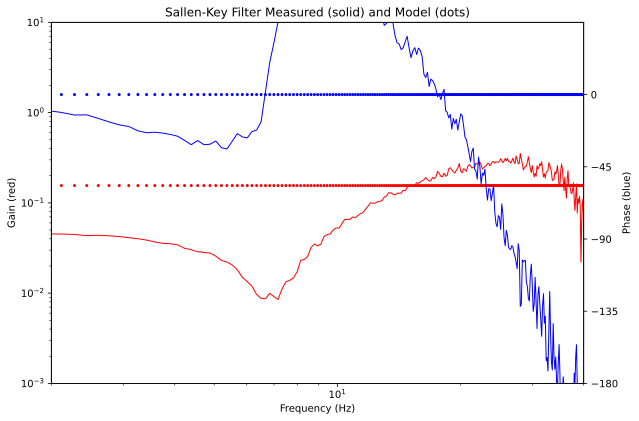

In [57]:
tfg=np.absolute(tf(1j*2*np.pi*f,gainest,dampingest,2*np.pi*natfreqest)) # substitute s for jw
tfp=360*np.angle(tf(1j*2*np.pi*f,gainest,dampingest,2*np.pi*natfreqest))/(2*np.pi) # substitute s for jw
    
plt.rcParams['figure.figsize'] = [9, 6]
fig, axa = plt.subplots()
    
axa.loglog(f, tfg,'r.',markersize=4)
axa.loglog(f, abs(Hxy),'r',linewidth=1)
axa.set_ylim([0.001,10])
axa.set_xlim([2,40])
axa.set(xlabel='Frequency (Hz)', ylabel='Gain (red)', title='Sallen-Key Filter Measured (solid) and Model (dots)')
    
axb=axa.twinx()
axb.semilogx(f, tfp,'b.',markersize=4)
axb.semilogx(f, 360*np.unwrap(np.angle(Hxy))/(2*np.pi),'b',linewidth=1)
axb.set(ylabel='Phase (blue)')
axb.set_ylim([-180,45])
axb.set_xlim([2,40])
axb.locator_params(axis = 'y', nbins = 8)
axb.set_yticks(np.arange(0,-182,-45))
    
plt.tight_layout()
plt.show()

Clearly we have a great fit.

Also note that the system static gain, $\alpha$, and damping parameter, $\zeta$, are both very close to unity. Indeed as we will see below this particular Sallen-Key filter was designed to have unity gain and unity damping parameter. 

Let's now consider the Sallen-Key filter and use it to predict the expected values of $\alpha$, $\omega_{n}$ and $\zeta$.

#### Sallen-Key Filter

The second-order Sallen-Key filter has the following circuit:

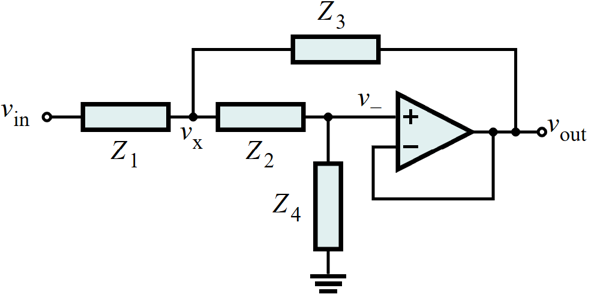

where Z1, Z2, Z3 and Z4 can each be any parallel or series combination of resistors, capacitors and inductors. By choosing what Z1, Z2, Z3, and Z4 are we can design a variety of second-order filters (low-pass, high-pass, band-pass and band-stop).

From https://upload.wikimedia.org/wikipedia/commons/e/e3/Sallen-Key_Generic _Circuit.svg

The general transfer function is:

$$ H(s) = \frac{Z3(s)Z4(s)}{Z1(s)Z2(s)+Z3(s)(Z1(s)+Z2(s))+Z3(s)Z4(s)}$$

#### Low-pass Filter

For the case of a second-order, low-pass, filter we have:

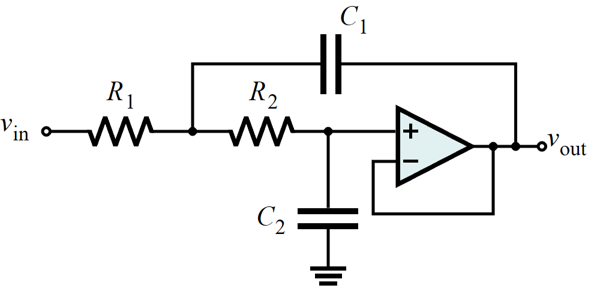

$Z1(s)=R1$

$Z2(s)=R2$

$Z3(s)=\frac{1}{C1.s}$

$Z4(s)=\frac{1}{C2.s}$

Combining these individual transfer functions we get the overall transfer function:

### $$H(s)=\frac{\frac{1}{C1.C2.R1.R2}}{s^2+\frac{R1+R2}{C1.R1.R2}s+\frac{1}{C1.C2.R1.R2}}$$

Note that this is the form of a second-order, low-pass, transfer function where

$$\alpha=1$$

$$\omega_n=\sqrt{\frac{1}{C1.C2.R1.R2}}$$

$$\zeta=\frac{R1+R2}{C1.R1.R2}\frac{\sqrt{C1.C2.R1.R2}}{2}$$

For example if we want the second-order low pass filter to have unity damping (i.e., $\zeta$ = 1) and a cutoff frequency (i.e., $\omega_{n}$) of around 1 kHz then we can set both resistors R1 = R2 = 10 k$\Omega$ and both capacitors C1 = C2 = 15 nF.

In [58]:
R1=1e4
R2=1e4
C1=15e-9
C2=15e-9

The natural frequency (cut-off frequency) will be:

In [59]:
(1/(C1*C2*R1*R2))**0.5/(2*np.pi) # Hz

1061.0329539459692

and the damping parameter, $\zeta$, will be

In [60]:
(R1+R2)/(C1*R1*R2)*((C1*C2*R1*R2)**0.5)/2

1.0

Compare these $\alpha$, $\zeta$ and $\omega_{n}$ values (1, 1, 1061) to those determined from the measured Sallen-Key filter response:

In [61]:
(gainest, dampingest, natfreqest)

(0.1555606082498892, -50.55428746170628, -172011372.9627198)

These are close! Note that the resistor and capacitors we used are not exactly 10 k$\Omega$ and 15 nF respectively. Standard metal film resistors are typically within 1% and the capacitors used here are typically within 5%.

#### Predicting the Sallen-Filter response to any input

As detailed above the Sallen-Key transfer function is:

$$ H(s) = \frac{\alpha \omega _{n}^2}{s^2+2\zeta\omega_ns+\omega_n^2} $$ 

with

$$\alpha=1$$

$$\zeta=1$$

$$\omega_n=2.\pi.1061$$

Remember the transfer function requires the natural frequency to be specified in rad/s.

Now that we know the transfer function of the Sallen-Key filter we can predict its output for any input.

#### Sallen-Key filter unit step response

We can determine the unit step response by multiplying the transfer function by 1/s and then inverse Laplace transforming. Or we can use the scipy functions as we did in previous notes:

In the standard form, the numerator and denominator polynomials are specified as:

$$ H(s) = \frac{b[0]s^m+b[1]s^{m-1}+\dots+b[m]}{a[0]s^n+a[1]s^{n-1}+ \dots +a[n]} $$

In [62]:
b=np.array([gainest*(2*np.pi*natfreqest)**2])
a=np.array([1.0,2.0*dampingest*2*np.pi*natfreqest,(2*np.pi*natfreqest)**2])

In [63]:
from scipy import signal
tau=np.arange(0, 0.002, dt)
tau,yp=signal.step((b,a),T=tau)

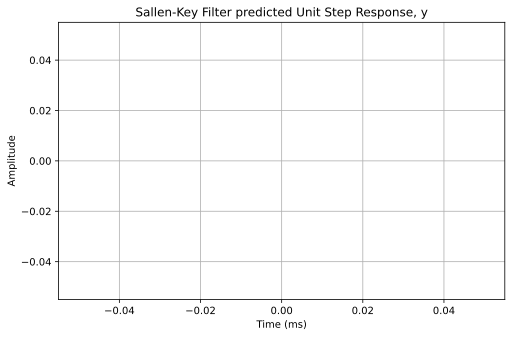

In [64]:
plt.rcParams['figure.figsize'] = [8, 5]
fig, ax = plt.subplots()
ax.plot(1000*tau, yp, 'r',linewidth=1)
ax.set(xlabel='Time (ms)', ylabel='Amplitude', title='Sallen-Key Filter predicted Unit Step Response, y')
ax.grid()
plt.show()